In [1]:
# gerneral System Imports
import os

import sys





#math imports
import numpy as np
import pandas as pd 
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat







# deep learning 
from keras.models import Sequential, load_model

from keras.layers import Dense, Dropout, Activation

from keras.layers import LSTM

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

from keras import optimizers

# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import logging
import matplotlib.pyplot as plt
#helper functions curtosy of https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo
import  lstm,time

Using TensorFlow backend.


In [2]:
df = read_csv('ge_open.csv')
df['Date']= pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Volume,Close
0,1962-01-02,0.6277,0.6362,0.6201,2575579,0.6201
1,1962-01-03,0.6201,0.6201,0.6122,1764749,0.6201
2,1962-01-04,0.6201,0.6201,0.6037,2194010,0.6122
3,1962-01-05,0.6122,0.6122,0.5798,3255244,0.5957
4,1962-01-08,0.5957,0.5957,0.5716,3696430,0.5957


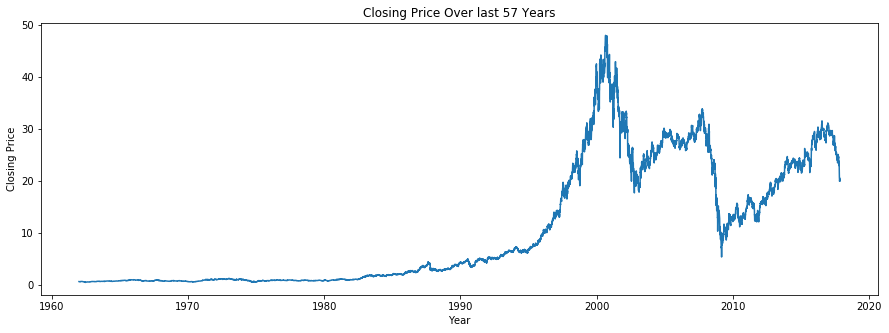

In [9]:
plt.figure(figsize=(15,5))
plt.plot(df.Date,df.Close)
plt.title("Closing Price Over last 57 Years")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.show()

In [149]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [234]:
dataset = read_csv('ge_open.csv', header=0, index_col=0)
values = dataset.loc[:,dataset.columns !='Close']
values = values.astype('float32')
values2 = dataset.loc[:,dataset.columns =='Close']

values2 = values2.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled2 = scaler2.fit_transform(values2)

scaled[newaxis,:]= scaled2
scaled

array([[0.00338425, 0.00338425, 0.00338425, 0.00338425],
       [0.00338425, 0.00338425, 0.00338425, 0.00338425],
       [0.00321827, 0.00321827, 0.00321827, 0.00321827],
       ...,
       [0.41307203, 0.41307203, 0.41307203, 0.41307203],
       [0.41034074, 0.41034074, 0.41034074, 0.41034074],
       [0.42084561, 0.42084561, 0.42084561, 0.42084561]])

In [235]:
n_hours = 10 # data used
n_features = 4 # features available

days_away = 90 # days in advance the prediction is made. 

days_away = days_away + n_hours


In [236]:
reframed = series_to_supervised(scaled,days_away,1)
reframed.head()

,var1(t-100),var2(t-100),var3(t-100),var4(t-100),var1(t-99),var2(t-99),var3(t-99),var4(t-99),var1(t-98),var2(t-98),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
100,0.003384,0.003384,0.003384,0.003384,0.003384,0.003384,0.003384,0.003384,0.003218,0.003218,...,0.002538,0.002538,0.002193,0.002193,0.002193,0.002193,0.002193,0.002193,0.002193,0.002193
101,0.003384,0.003384,0.003384,0.003384,0.003218,0.003218,0.003218,0.003218,0.002872,0.002872,...,0.002193,0.002193,0.002193,0.002193,0.002193,0.002193,0.001861,0.001861,0.001861,0.001861
102,0.003218,0.003218,0.003218,0.003218,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,...,0.002193,0.002193,0.001861,0.001861,0.001861,0.001861,0.001351,0.001351,0.001351,0.001351
103,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,...,0.001861,0.001861,0.001351,0.001351,0.001351,0.001351,0.001687,0.001687,0.001687,0.001687
104,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,0.002872,...,0.001351,0.001351,0.001687,0.001687,0.001687,0.001687,0.001861,0.001861,0.001861,0.001861


In [237]:
values = reframed.values

In [238]:
n_train_hours = 365*30 # train on the first 30 years of data
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10950, 40) 10950 (10950,)
(10950, 10, 4) (10950,) (3008, 10, 4) (3008,)


In [239]:
train_X[0]

array([[0.00338425, 0.00338425, 0.00338425, 0.00338425],
       [0.00338425, 0.00338425, 0.00338425, 0.00338425],
       [0.00321827, 0.00321827, 0.00321827, 0.00321827],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161],
       [0.00270563, 0.00270563, 0.00270563, 0.00270563],
       [0.00287161, 0.00287161, 0.00287161, 0.00287161]])

In [247]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),
              return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

compilation time :  0.026000499725341797


In [248]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 50)            11000     
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 71,501
Trainable params: 71,501
Non-trainable params: 0
_________________________________________________________________


In [249]:
history = model.fit(
    train_X,
    train_y,
    batch_size=512,
    nb_epoch=14,
    validation_split=0.05)

Train on 10402 samples, validate on 548 samples
Epoch 1/14
10402/10402 [==============================] - 5s 515us/step - loss: 0.0068 - val_loss: 0.0154
Epoch 2/14
10402/10402 [==============================] - 1s 112us/step - loss: 0.0025 - val_loss: 0.0010
Epoch 3/14
10402/10402 [==============================] - 1s 107us/step - loss: 0.0025 - val_loss: 0.0055
Epoch 4/14
10402/10402 [==============================] - 1s 110us/step - loss: 0.0022 - val_loss: 0.0046
Epoch 5/14
10402/10402 [==============================] - 1s 104us/step - loss: 0.0022 - val_loss: 0.0108
Epoch 6/14
10402/10402 [==============================] - 1s 114us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 7/14
10402/10402 [==============================] - 1s 101us/step - loss: 0.0022 - val_loss: 9.2084e-04
Epoch 8/14
10402/10402 [==============================] - 1s 102us/step - loss: 0.0021 - val_loss: 0.0047
Epoch 9/14
10402/10402 [==============================] - 1s 105us/step - loss: 0.0021 - val_loss: 0

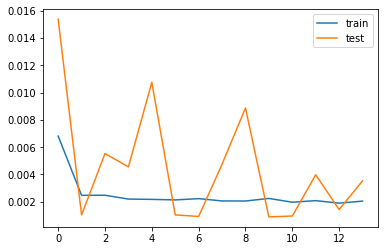

In [250]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [253]:
preds = (model.predict(test_X))
preds = preds.reshape(-1,1)
preds = scaler2.inverse_transform(preds)
test_y = test_y.reshape(-1,1)
true = scaler2.inverse_transform(test_y)

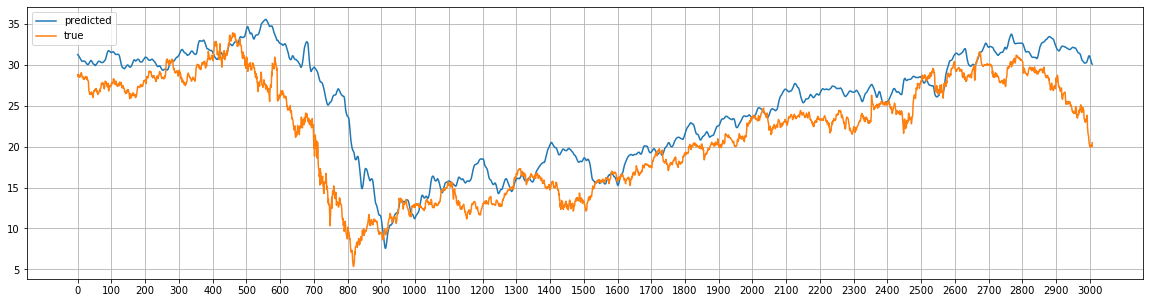

In [254]:
plt.figure(figsize=(20,5))
plt.plot(preds,label='predicted')
plt.plot(true, label='true')
#plt.plot(train_predict_plot,label='idk')
plt.xticks(range(0,len(true),days_away),label=None)
plt.grid()
plt.legend()
pyplot.show()

In [180]:
look_back = 0
train_predict_plot = np.empty_like(preds)
train_predict_plot[:,:] = np.nan 
train_predict_plot[look_back:len(preds) +look_back,:] = preds

In [74]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [i for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [30]:
from numpy import newaxis

In [31]:
import time, sys
from IPython.display import clear_output
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [80]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    ranger = int(len(data)/prediction_len)
    print(ranger)
    for i in range(ranger):
        print(i)
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:]))
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
        update_progress(j/prediction_len)
    return prediction_seqs

In [35]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [107]:
preds = predict_sequences_multiple(model,test_X,10,10)

Progress: [##################--] 90.0%


In [109]:
preds = np.array(preds)

In [113]:
preds.reshape((10,1))

ValueError: cannot reshape array of size 3000 into shape (10,1)

In [110]:
preds.shape

(300, 10, 1, 1)

yo


ValueError: x and y can be no greater than 2-D, but have shapes (10,) and (10, 1, 0)

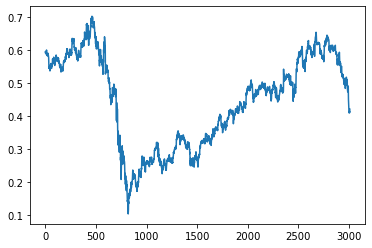

In [99]:
plot_results_multiple(preds, true, 100)